In [1]:
from indra_cogex.sources.odinson.grammars import Rule
from indra_cogex.sources.odinson.client import process_rules
import gilda
import pandas as pd
from collections import defaultdict
from gilda.process import normalize
from tqdm.auto import tqdm
from pyobo.gilda_utils import get_gilda_terms
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import textwrap
import random
import difflib

import indra_cogex
print(indra_cogex.__file__)

/Users/sangeethavempati/.virtualenvs/newnotebook/lib/python3.11/site-packages/indra_cogex/__init__.py


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sangeethavempati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import spine_ner
grounder = spine_ner.grounder


[UBERON] mapping:   0%|          | 0.00/14.5k [00:00<?, ?name/s]

[UBERON] mapping:   0%|          | 0.00/10.1k [00:00<?, ?synonym/s]

[fma] mapping:   0%|          | 0.00/79.0k [00:00<?, ?name/s]

[fma] mapping:   0%|          | 0.00/29.8k [00:00<?, ?synonym/s]

In [3]:
from itertools import product
import rule_gen 

noun_case_f = rule_gen.noun_case_f

phenotype_f = rule_gen.phenotype_f

binary_rules = []
ph_rules = []

br_br_rules = [rule_gen.create_br_br_rules(br_1,br_2) for br_1,br_2 in product(noun_case_f,noun_case_f)]

br_ph_rules = [rule_gen.create_br_ph_rules(br,ph) for br,ph in product(noun_case_f,phenotype_f)]


for rule_set in br_br_rules:
    for individual_rule in rule_set:
        binary_rules.append(individual_rule)

for rule_set in br_ph_rules:
    for individual_rule in rule_set:
        ph_rules.append(individual_rule)


print(len(binary_rules))
print(len(ph_rules))



7581
5434


In [4]:

import stop_words 

sw_nltk = stop_words.sw_nltk
false_phrases = stop_words.false_phrases
exclude_words = stop_words.exclude_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sangeethavempati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
relations = []
readable_sentences = []
br_full_relations = []
br_rule_relation = []

#go through each rule and make it a rule object
for rule_text in tqdm(binary_rules):
    rule = Rule("anatomical connection", "Exp", "basic", rule_text)
    #make sure it is a functional Odinson rule
    try:
        rule_output = process_rules([rule],"http://localhost:9000")
    
    except Exception as e:
        print('failed', rule)
        print(e)
    '''
    with open('failed rules.txt', 'a') as file:
        #file.write('failed' + '\n')
        file.write(str(rule))
    continue
    '''
    #get the start and end characters for each term pulled out by the rule
    for sentence in rule_output['mentions']:
        relation = ()
        words = sentence['words']
        string_words = ' '.join(words)
        readable_sentences += [string_words]
        for element in sentence['match']:  
            for entity in element['namedCaptures']:
                start = entity['capturedMatch']['start']
                end = entity['capturedMatch']['end']
                #print(words[start:end])
                #remove stop words
                processed_term = [word for word in words[start:end] if word.lower() not in sw_nltk]
                word = ' '.join(processed_term)
                if word.lower() not in exclude_words:                   
                    #create tuples with curies for terms that can be grounded
                    spine_scored_match = grounder.ground(word)
                    gilda_scored_match = gilda.ground(word)
    
                    if len(spine_scored_match)>0:
                        best_curie = spine_scored_match[0].term.get_curie()
                    elif len(gilda_scored_match)>0:
                        best_curie = gilda_scored_match[0].term.get_curie()
                    else:
                        best_curie = None

                    if word != '' and best_curie != None:
                        relation += ((best_curie, word),)  
        if len(relation) > 1 and relation not in relations and relation[0][1] != relation[1][1]:
            relations.append(relation)
            br_full_relations += [[relation,string_words]]
            br_rule_relation += [[relation,string_words,rule_text]]

print(len(relations))


  0%|          | 0/7581 [00:00<?, ?it/s]

354


In [6]:
ph_relations = []
full_relation = []
#readable_sentences = []
#go through each rule and make it a rule object
for rule_text in tqdm(ph_rules):
    rule = Rule("phenotype", "Exp", "basic", rule_text)
    #make sure it is a functional Odinson rule
    try:
        rule_output = process_rules([rule],"http://localhost:9000")
    
    except Exception as e:
        print('failed', rule)
        print(e)

    #get the start and end characters for each term pulled out by the rule
    for sentence in rule_output['mentions']:
        relation = ()
        words = sentence['words']
        string_words = ' '.join(words)
        #readable_sentences += [string_words]
        for element in sentence['match']:
            for entity in element['namedCaptures']:
                start = entity['capturedMatch']['start']
                end = entity['capturedMatch']['end']
                #remove stop words
                #processed_term = [word for word in words[start:end] if word.lower() not in sw_nltk and word.lower() not in false_phrases and word.lower() not in exclude_words]
                processed_term = []
                for word in words[start:end]:
                    if word.lower() not in sw_nltk and word.lower() not in false_phrases and word.lower() not in exclude_words:
                        #print(word)
                        processed_term += [word]
                word = ' '.join(processed_term)
                #create tuples with curies for terms that can be grounded
                spine_scored_match = grounder.ground(word)
                gilda_scored_match = gilda.ground(word)
                
                if len(gilda_scored_match)>0:
                    best_curie = gilda_scored_match[0].term.get_curie()
                elif len(spine_scored_match)>0:
                    best_curie = spine_scored_match[0].term.get_curie()
                else:
                    best_curie = None

                if word != '':
                    relation += ((best_curie, word),)  
        if len(relation) > 1 and relation not in ph_relations:
            ph_relations.append(relation)
            full_relation += [[relation,string_words,rule_text]]

print(len(ph_relations))
print(ph_relations)

  0%|          | 0/5434 [00:00<?, ?it/s]

149
[((None, 'cerebral'), ('DOID:1307', 'dementia')), (('fma:74533', 'posterior'), ('hgnc:13633', 'AD')), ((None, 'central nervous'), ('mesh:D019636', 'neurodegenerative diseases')), (('mesh:D002490', 'CNS'), (None, "Alzheimer 's disease")), ((None, 'medial orbitofrontal'), ('GO:0007610', 'behavior')), (('CHEBI:38323', 'cholinergic'), ('mesh:D009422', 'neurological disorders')), (('mesh:D002490', 'CNS'), ('mesh:D012598', 'sclerosis')), ((None, 'central nervous'), ('mesh:D004194', 'disorders')), ((None, 'central nervous'), (None, "Alzheimer 's disease")), (('mesh:D009417', 'nervous tissue'), (None, "Alzheimer 's disease")), (('mesh:D009417', 'nervous tissue'), (None, "'s syndrome")), (('mesh:D008995', 'MAO'), (None, "Alzheimer 's disease")), (('uberon:0003027', 'cingulate cortex'), ('GO:0007613', 'memory')), (('hgnc:2434', 'CSF'), ('DOID:1307', 'dementia')), ((None, 'caudate'), ('mesh:D057174', 'frontotemporal lobar degeneration')), ((None, 'central nervous'), ('mesh:D004827', 'epilepsy

In [8]:
#create a sample set of 20 random sentences
sample_set = random.sample(readable_sentences,20)

with open('sample_20.txt', 'w') as f:
    for sentence in sample_set:
        f.write(sentence + '\n')

In [40]:
#compare a .txt of shell output with the results from this script 
inPhrase = False
current_substring = ''
orig_sentences_shell = []
with open('odinson_shell.txt', 'r') as file:
    for char in file.read():
        if inPhrase == True and char != '\n':
            current_substring += char
        if char == ')':
            inPhrase = True
        if inPhrase == True and char == '.':
            inPhrase = False
            orig_sentences_shell += [current_substring]
            current_substring = ''

sentence_dup = []
checked = []
dup = False
for sentence in readable_sentences:
    if sentence in checked:
        dup = True
        sentence_dup += [sentence]
    if dup == False:
        checked += [sentence]
    dup = False

print(sentence_dup)

sentences_shell = []
for sentence in orig_sentences_shell:
    if sentence not in sentences_shell:
        sentences_shell.append(sentence)
sentences_script = []
for sentence in readable_sentences:
    if sentence not in sentences_script:
        sentences_script.append(sentence)

#print(len(sentences_shell))
#print(len(sentences_script))

not_overlap = []
overlap = []
for sentence in readable_sentences:
    if sentence not in orig_sentences_shell:
        not_overlap += [sentence]
    else:
        overlap += [sentence]
        

#print(len(not_overlap))

        

['The laminar and tangential distributions of association neurons projecting from areas 4 and 6 of the frontal lobe to area 5 of the superior parietal lobule were studied in macaque monkeys by using horseradish peroxidase histochemistry .', 'Overall , there was a higher proportion of neurons projecting from areas V1 , V2 , V3 , and V3A to area MT that were neurofilament protein-immunoreactive ( 57-100 % ) , than to area V4 ( 25-36 % ) .', 'Overall , there was a higher proportion of neurons projecting from areas V1 , V2 , V3 , and V3A to area MT that were neurofilament protein-immunoreactive ( 57-100 % ) , than to area V4 ( 25-36 % ) .', 'Overall , there was a higher proportion of neurons projecting from areas V1 , V2 , V3 , and V3A to area MT that were neurofilament protein-immunoreactive ( 57-100 % ) , than to area V4 ( 25-36 % ) .', 'The distribution of neurons projecting from the retina and visual cortex to the thalamus and tectum opticum of the barn owl , Tyto alba , and the burrow

In [7]:
#create a ranked list of terms from br_br
import csv
import numpy as np

'''with open('relations.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(relations)'''
terms = []
for set in relations:
    for term in set:
        terms.append(term[1])

        
new_relations = np.array(terms)

ranked = pd.value_counts(new_relations)

value_counts_df = ranked.reset_index()
value_counts_df.columns = ['Value', 'Count']

with open('relations.csv', 'w') as f:
    value_counts_df.to_csv(f, index=False)

In [19]:
#create a ranked list of terms from br_ph
import csv
import numpy as np

'''with open('relations.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(relations)'''
terms = []
for set in ph_relations:
    for term in set:
        terms.append(term[1])

        
new_relations = np.array(terms)

ranked = pd.value_counts(new_relations)

value_counts_df = ranked.reset_index()
value_counts_df.columns = ['Value', 'Count']

with open('ph_relations.csv', 'w') as f:
    value_counts_df.to_csv(f, index=False)

In [6]:
#create a csv file of all relations
import csv
'''
with open('relation_full.csv', 'w', newline='') as f:    
    csv_writer = csv.writer(f)

    for relation1, relation2 in relations_short:
        term_of_inner_tuple1 = relation1[1]
        term_of_inner_tuple2 = relation2[1]
        #print(term_of_inner_tuple1,term_of_inner_tuple2)
        csv_writer.writerow([term_of_inner_tuple1, term_of_inner_tuple2])
'''
'''
with open('relation_full_sen_benchmark_9.11_lastditch.csv', 'w', newline='') as f:    
    csv_writer = csv.writer(f)
    for full in br_full_relations:
        sentence = full[1]
        tuple = full[0]
        #print(tuple)
        #term_of_inner_tuple1 = tuple[1][1]
        #term_of_inner_tuple2 = tuple[0][1]
        #print(term_of_inner_tuple1)
        #print(term_of_inner_tuple2)
        #print(sentence)
        csv_writer.writerow([tuple[0], tuple[1],sentence])
'''
with open('br_benchmark_rule_9.17.csv', 'w', newline='') as f:    
    csv_writer = csv.writer(f)
    for full in br_rule_relation:
        rule = full[2]
        sentence = full[1]
        tuple = full[0]
        #print(tuple)
        term_of_inner_tuple1 = tuple[1][1]
        term_of_inner_tuple2 = tuple[0][1]
        #print(term_of_inner_tuple1)
        #print(term_of_inner_tuple2)
        #print(sentence)
        csv_writer.writerow([term_of_inner_tuple1, term_of_inner_tuple2,sentence,rule])
'''
with open('relation_full_sen_ph_8.22.csv', 'w', newline='') as f:    
    csv_writer = csv.writer(f)
    for full in full_relation:
        rule = full[2]
        sentence = full[1]
        tuple = full[0]
        #print(tuple)
        term_of_inner_tuple1 = tuple[1][1]
        term_of_inner_tuple2 = tuple[0][1]
        #print(term_of_inner_tuple1)
        #print(term_of_inner_tuple2)
        #print(sentence)
        csv_writer.writerow([term_of_inner_tuple1, term_of_inner_tuple2,sentence,rule])
'''

"\nwith open('relation_full_sen_ph_8.22.csv', 'w', newline='') as f:    \n    csv_writer = csv.writer(f)\n    for full in full_relation:\n        rule = full[2]\n        sentence = full[1]\n        tuple = full[0]\n        #print(tuple)\n        term_of_inner_tuple1 = tuple[1][1]\n        term_of_inner_tuple2 = tuple[0][1]\n        #print(term_of_inner_tuple1)\n        #print(term_of_inner_tuple2)\n        #print(sentence)\n        csv_writer.writerow([term_of_inner_tuple1, term_of_inner_tuple2,sentence,rule])\n"


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


/var/folders/wr/rjbgc51d66b85txy420qqdch0000gn/T/ipykernel_4643/4166572946.py:31: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=1.0, edge_color=edge_colors, style='solid')


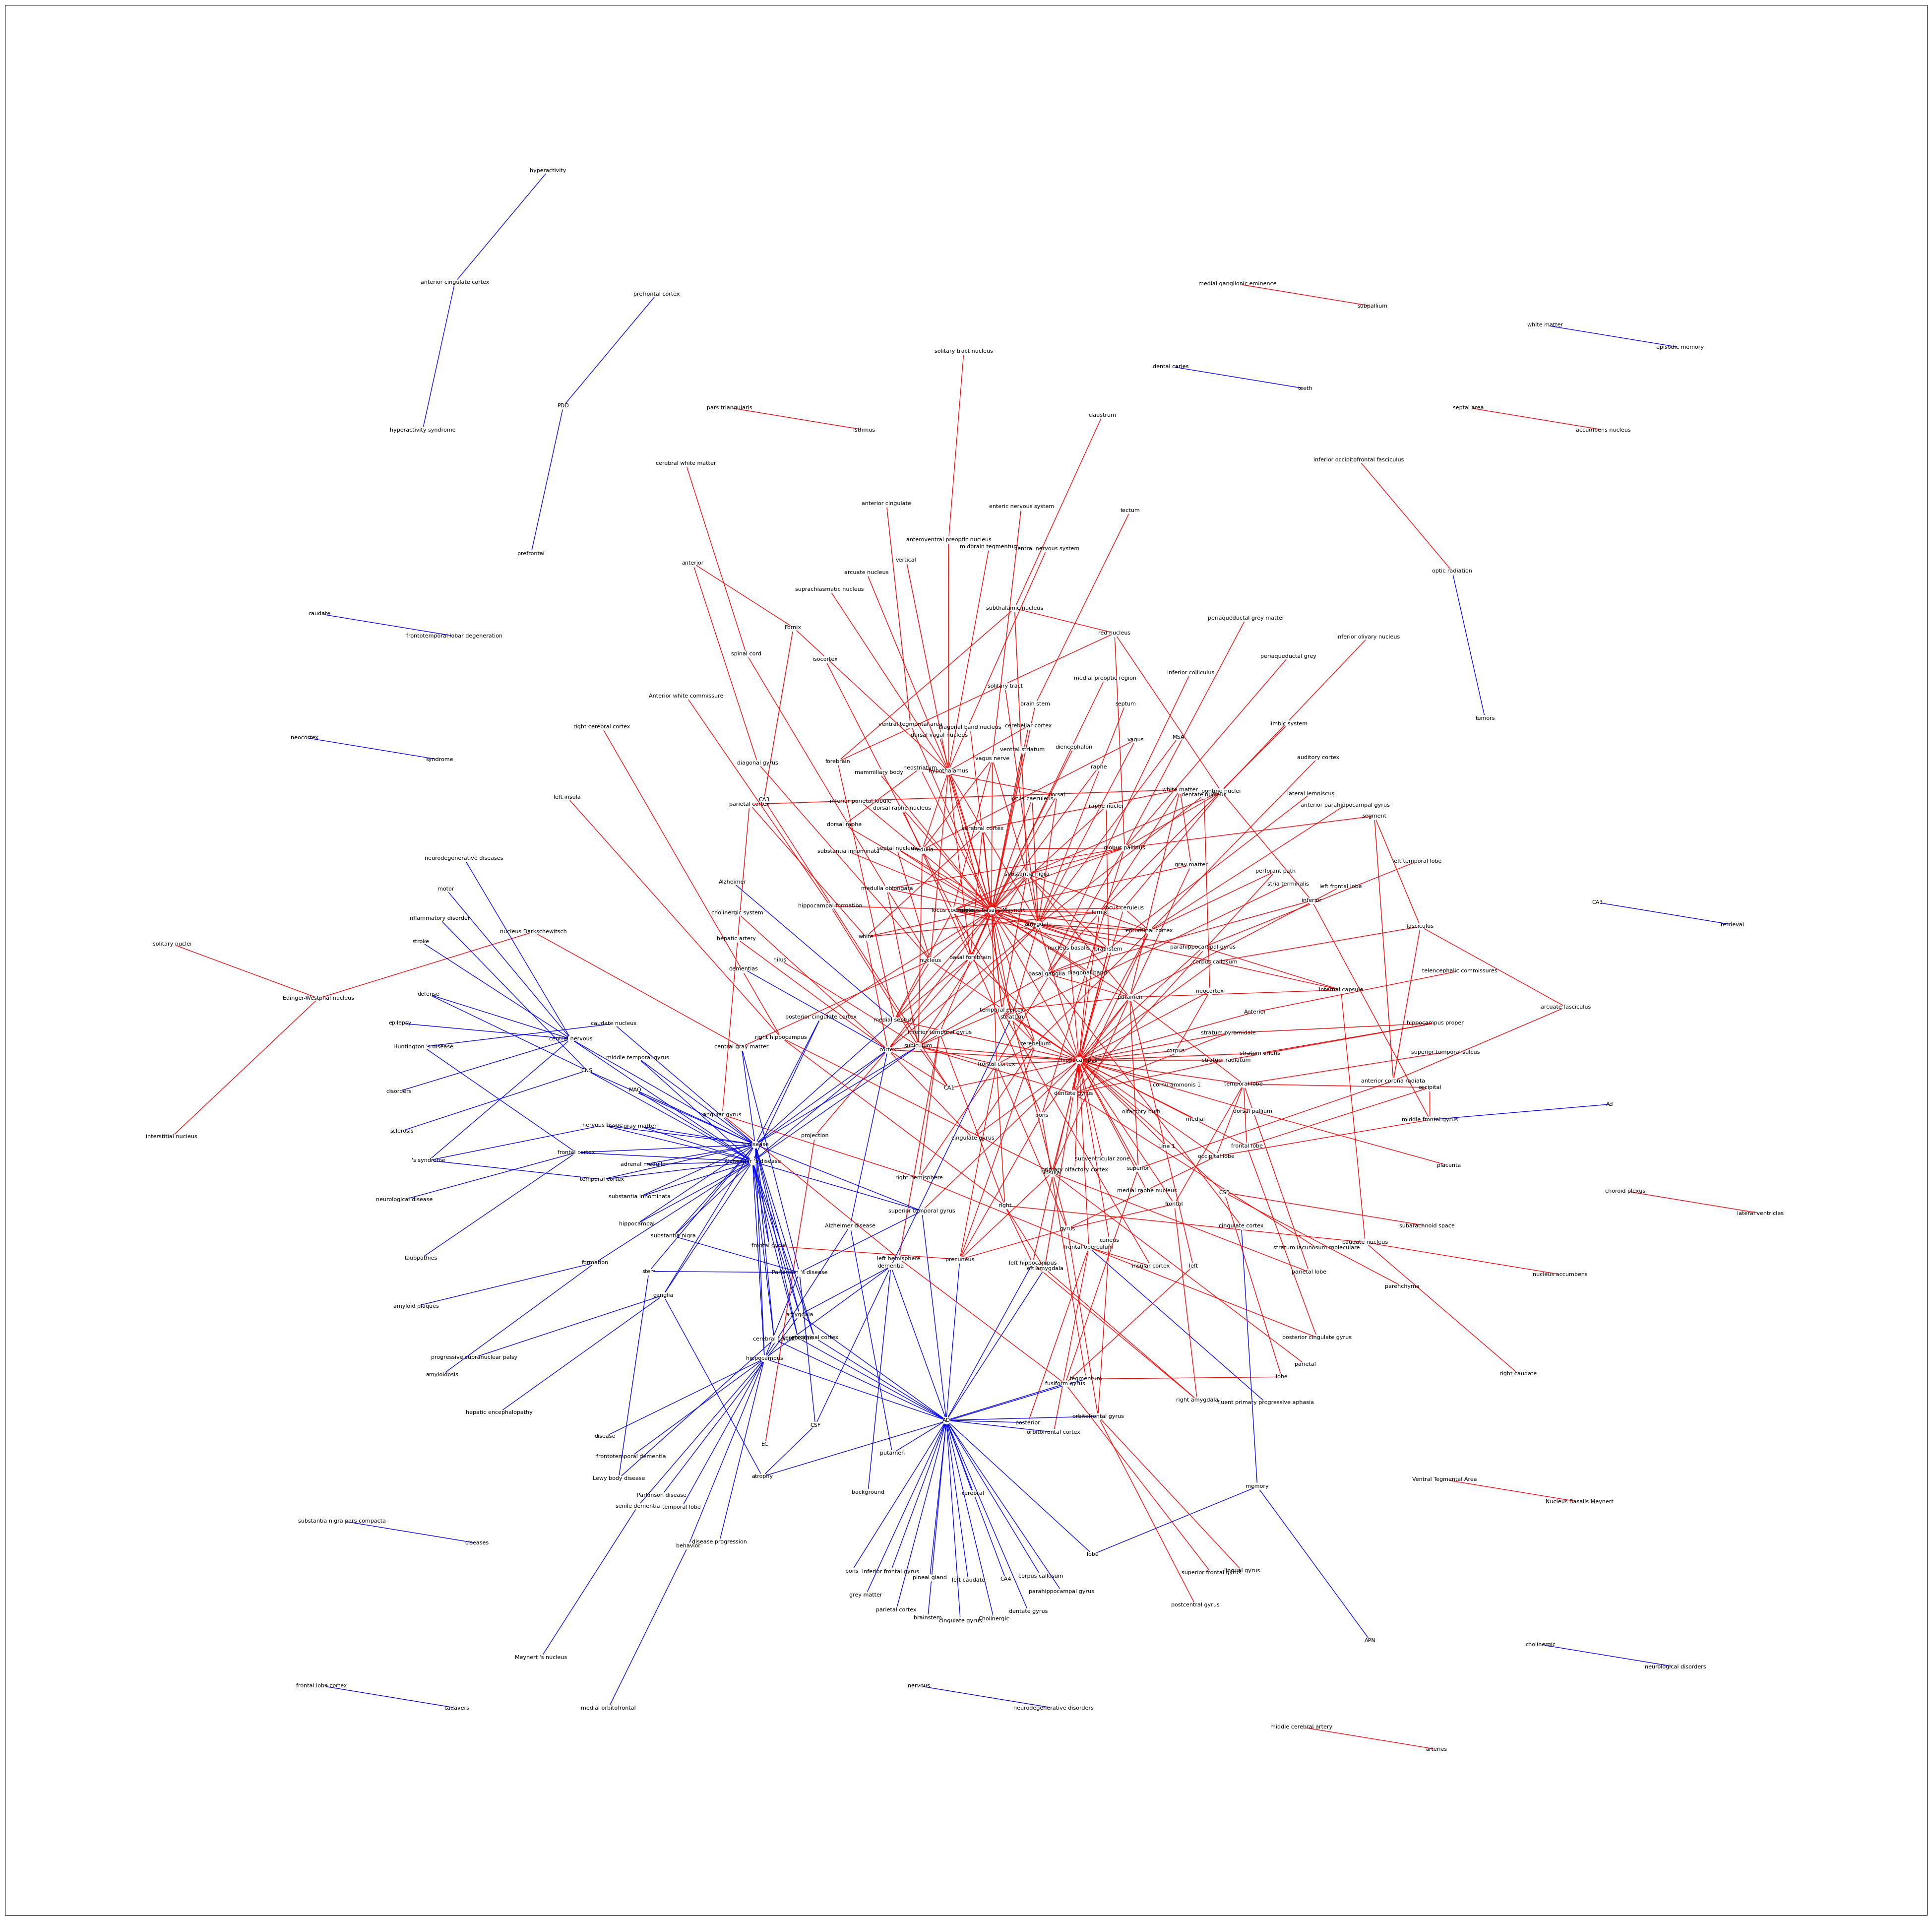

In [9]:
#create an interaction map of relationships between brain region terms
!pip install matplotlib
import networkx as nx
import pygraphviz as pgv
import matplotlib.pyplot as plt
G = nx.Graph()
plt.figure(figsize=(50,50))
G.add_edges_from(relations, len=4,color='red')
G.add_edges_from(ph_relations, len=4,color='blue')

#G.add_edges_from(relations, len=4,color='green')
#G.add_edges_from(ph_relations, len=4,color='blue')

edge_colors = [G.edges[edge]['color'] for edge in G.edges]


pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
#labels = {n: n[1] for n in G.nodes()}
labels = {}
for k in pos.keys():
    labels[k] = k[1]

'''
for label in labels.values():
    textwrap.wrap(label, width = 10)
    print(label)
'''
#G = nx.relabel_nodes(G, labels)
#nx.draw_networkx_labels(G, pos, labels, font_size=22, font_color="black")
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='white', node_shape='o')
nx.draw_networkx_edges(G, pos, width=1.0, edge_color=edge_colors, style='solid')
labels = nx.draw_networkx_labels(G, pos, labels = labels, font_size=8, font_color='k', font_family='sans-serif', font_weight='normal')
#nx.draw(G, pos, with_labels=True, edge_color=edge_colors, font_color='white', font_weight='bold', node_size=700, font_size=10)

print()
plt.savefig("alzheimers.pdf")

In [10]:
# Count the number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print out the counts
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 297
Number of edges: 483


In [ ]:
benchmark_url = ('https://docs.google.com/spreadsheets/d/e/2PACX-1vS6uvih2Hi7dIo9Nabk5gv2kz67avmHpiWvqtNOKxrr43WhxSCBwzyq'
'lLvi841Vx3f1LoF7GF_5Cff3/pub?output=tsv')
benchmark_df = pd.read_csv(benchmark_url, sep='\t')
subject = gilda.ground_df(benchmark_df, 'subject', grounder=grounder)
object = gilda.ground_df(benchmark_df, 'object', grounder=grounder)

benchmark_df
